In [1]:
!pip install segmentation_models_pytorch
import os
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from IPython.display import clear_output
import cv2
from torchvision import transforms
import copy
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from numba import jit
import time
import math
from PIL import ImageChops

clear_output() 

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# параметры обучения
LEARNING_RATE = 3e-4
BATCH_SIZE    = 4 # 64
NUM_EPOCHS    = 5
STEP_SIZE = 100
GAMMA = 0.6

# Размеры картинки на вход в модель
IMAGE_HEIGHT  = 384  
IMAGE_WIDTH   = 384

# путь для загрузи модели
MODEL_PATH = '/kaggle/working/model_jew_detect_01.05.2023.md'
INPUT_TRANSPARENT_DIR = '/kaggle/input/jewellery/raw_data_all/raw_data_all'

NAME_MODEL_FOR_LOADING = '/kaggle/input/jewellery/models/model_jew_detect_01.05.2023.md'

REAL_PATH = '/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/house_data'
ROCK_PAPER_SCISSORS_PATH = '/kaggle/input/rock-paper-scissors-dataset/train'
AAA_PATH  = '/kaggle/input/jewellery/aaa-jewellery-images/aaa-jewellery-images'
MANUAL_DIR = '/kaggle/input/jewellery/images_manual/images_manual'


# константы для настройки генерации изобржажений
# вероятности добавления фигур при генерерации фона
PROBABILITY_ADD_RANDOM_RECTANGLE = 0.25
PROBABILITY_ADD_RANDOM_LINE = 0.75
PROBABILITY_ADD_RANDOM_ELLIPSE = 0.75
# количество добавленных фигур при генерерации фона - равномерная вероятность "минимальное" и "максимальное" количество
N_RANDOM_RECTANGLE = (1,6)
N_RANDOM_LINE = (1,6)
N_RANDOM_ELLIPSE = (1,6)
# вероятности добавления изображения комнаты в качестве фона при генерерации фона
PROBABILITY_ADD_ROOM = 0.5
# задает на сколько раз фон больше изображения при генерерации фона.
K_RATIO = 2
# подкладывает под изображение в качества фона сгенеренированный фон с вероятностью PROBABILITY_ADD_SYNTHETIC_BACKGROUND 
PROBABILITY_ADD_SYNTHETIC_BACKGROUND = 0.66

# константы для настройки аугментации изобржажений
PROBABILITY_AUG_ROTATE = 0.5
PROBABILITY_AUG_FLIP = 0.7
PROBABILITY_AUG_HUE = 0.7
PROBABILITY_AUG_ADJUST_CONTRAST = 0.7

STEPS_FOR_THRESHOLD = [0.8, 0.7, 0.6, 0.5]


cuda


## Случайное изображение из датасета объектов

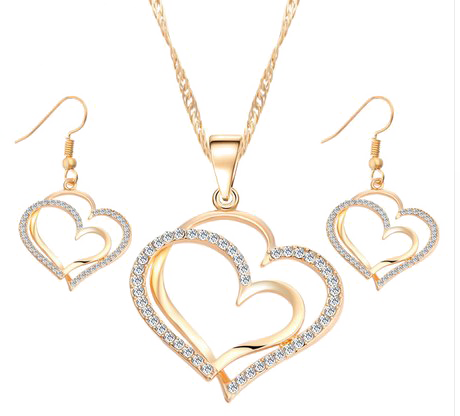

In [4]:
image_path = '/kaggle/input/jewellery/raw_data_all/raw_data_all/' + random.choice(os.listdir('/kaggle/input/jewellery/raw_data_all/raw_data_all'))
image = Image.open(image_path)
image

In [5]:
def generate_background(w : int, h : int, lighten_range = [0.05, 0.95], amount = 1):
    '''
    Создает размытый фон, поверх которого можно накладывать изображение
    
    :param h: высота фона
    :param w: ширина фона
    :param lighten_range: задает тон
    :param amount: задает зернистость    
    :return: изображение типа Image формата RGB размером (w, h)    
    '''
    white_list = np.zeros((h,w,3))
    max_col = 255

    # добавляет шум типа "salt"
    amount = 1
    nb_salt = np.ceil(amount * white_list.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_salt)) for i in white_list.shape]
    white_list[coords] = 0

    # добавляет шум типа "pepper"
    nb_pepper = np.ceil(amount* white_list.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_pepper)) for i in white_list.shape]
    white_list[coords] = 1

    lighten = np.array([random.uniform(*lighten_range) for i in range(3)]) 

    white_list = 1-(1-white_list)*lighten

    # создание шума
    white_list = Image.fromarray((white_list * max_col).astype(np.uint8))
    white_list = white_list.filter(ImageFilter.GaussianBlur(5))    
        
    # добавление абстрактных фигур
    draw = ImageDraw.Draw(white_list)
    
    # добавление случайных прямоугольников
    if random.random() > PROBABILITY_ADD_RANDOM_RECTANGLE:
        for i in range( random.randint(*N_RANDOM_RECTANGLE)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            x1, x2 = min(x1, x2), max(x1, x2),
            y1, y2 = min(y1, y2), max(y1, y2),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            color2 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            draw.rectangle((x1, y1, x2, y2), fill=color1, outline=color2)
        
    # добавление случайных линий
    if random.random() > PROBABILITY_ADD_RANDOM_LINE:
        for i in range( random.randint(*N_RANDOM_LINE)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            width1 = random.randint(0, 20)
            draw.line((x1, y1, x2, y2), fill=color1, width=width1)               
        
    # добавление случайных эллипсов
    if random.random() > PROBABILITY_ADD_RANDOM_ELLIPSE:
        for i in range( random.randint(*N_RANDOM_ELLIPSE)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            x1, x2 = min(x1, x2), max(x1, x2),
            y1, y2 = min(y1, y2), max(y1, y2),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            color2 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            draw.ellipse((x1, y1, x2, y2), fill=color1, outline=color2)       
        
    white_list = white_list.filter(ImageFilter.GaussianBlur(1))    
    
    return white_list

## Пример генерации фона

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


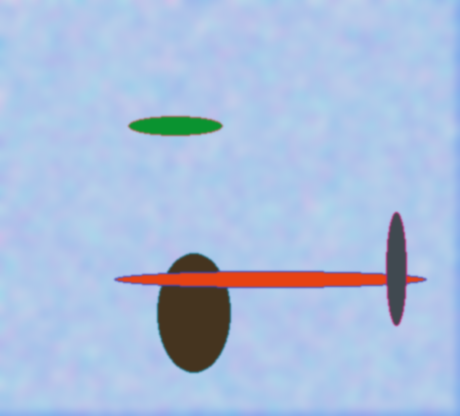

In [6]:
background = generate_background(*image.size)
background

In [7]:
def get_real_background(w:int, h:int):
    '''
    Создает фон, из датасетов реальных картинок, среди которых могут быть
    - комнаты с интерьером
    - руки
    
    :param w: ширина изображения
    :param h: высота изображения        
    :return: изображение типа Image формата RGB размером (w, h)   
    '''
        
    # добавляет в качества фона изображение комнады с вероятность PROBABILITY_ADD_ROOM
    # в противно случае добавляет в качества фона изображение рук    
    if random.random() > PROBABILITY_ADD_ROOM:
        path = REAL_PATH
    else:
        path = os.path.join(ROCK_PAPER_SCISSORS_PATH, random.choice(['paper', 'rock', 'scissors']) )
        
                
    real_images_list = os.listdir(path)    
    image_name = random.choice(real_images_list)   
    img_path = os.path.join(path, image_name)            
    image = Image.open(img_path)
            
    image = image.resize((w, h))      
    return image 

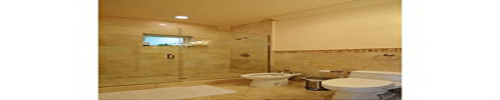

In [8]:
get_real_background(500,100)

In [9]:
def add_background(image:Image, k=2):
    '''
    Накладывает изобрежание image на случайный фон, который может быть или сгенерированным, или реальным.
    
    :param image: изображение типа PIL Image
    :param k: во сколько раз фон больше изображения image       
    :return: изображение типа Image формата RGB того же размера, что и image
    '''    

    # задает размер фона 
    w0 = image.size[0]
    h0 = image.size[1]              
    w = int((k * random.random()+1) * w0)
    h = int((k * random.random()+1) * h0)   
 
    # задает положение изображения поверх фона 
    w_shift = int((w - w0) * random.random())
    h_shift = int((h - h0) * random.random())      
    image_size = w, h
    shift = (w_shift, h_shift)
    
    # подкладывает под изображение в качества фона сгенеренированный фон с вероятностью PROBABILITY_ADD_SYNTHETIC_BACKGROUND 
    # в потивном случае одкладывает под изображение в качества фона картинки с "реальным" фоном (комната или руки)       
    if random.random() > PROBABILITY_ADD_SYNTHETIC_BACKGROUND:
        output = generate_background(*image_size)
    else:
        output = get_real_background(*image_size)
        
    output = output.convert('RGBA')    
    output.paste(image, shift, image)
    return output

In [10]:
def get_box_from_rgba(image:Image):
    '''
    Находит габариты изображений на фото, иначе говоря, находит координаты detection box
    
    :param image: изображение типа PIL Image
    :return: координаты detection box в формате x0, y0, x1, y1
    '''    
    mask = np.array(image)[:,:,3] <= 254
    
    ax = np.where(mask.max(axis=0) == True)[0]   
    x0, x1 = min(ax), max(ax)
    ax = np.where(mask.max(axis=1) == True)[0]  
    y0, y1 = min(ax), max(ax)       
    
    return x0, y0, x1, y1

In [11]:
image = add_background(image, k=K_RATIO)

In [12]:
def draw_box_on_image(image:Image, x0:int, y0:int, x1:int, y1:int, color='green'):
    '''
    Выводит изображение с нанесенной detection box
    
    :param image: изображение типа PIL Image
    :param x0: x координата левого верхнего угла
    :param y0: y координата левого верхнего угла
    :param x1: x координата правого нижнего угла
    :param y1: y координата правого нижнего угла
    :param color: цвет рамки
    :return: Выводит изображение с нанесенной detection box
    '''        
    show_box = copy.copy(image)
    draw=ImageDraw.Draw(show_box)
    draw.rectangle([(x0, y0),(x1, y1)],outline=color, width=3)
    return show_box    

In [13]:
def draw_box_on_image_multi(image:Image, xy:list, color='green'):
    '''
    Выводит изображение с несколькими нанесенной detection box
    
    :param image: изображение типа PIL Image
    :param xy: список координат detection box в формате x0, y0, x1, y1
    :param color: цвет рамки
    :return: Выводит изображение с нанесенной detection box
    '''  
                            
    show_box = copy.copy(image)
    draw=ImageDraw.Draw(show_box)
    
    for data in xy:
        x0, y0, x1, y1 = data[0],data[1],data[2],data[3]
        
        draw.rectangle([(x0, y0),(x1, y1)],outline=color, width=3)
    return show_box   

In [14]:
def draw_image_with_box(image:Image):
    '''
    Выводит изображение с  нанесенной detection box
    
    :param image: изображение типа PIL 
    :return: Выводит изображение с нанесенной detection box
    '''      
    x0, y0, x1, y1 = get_box_from_rgba(image)       
    return draw_box_on_image(image, x0, y0, x1, y1)

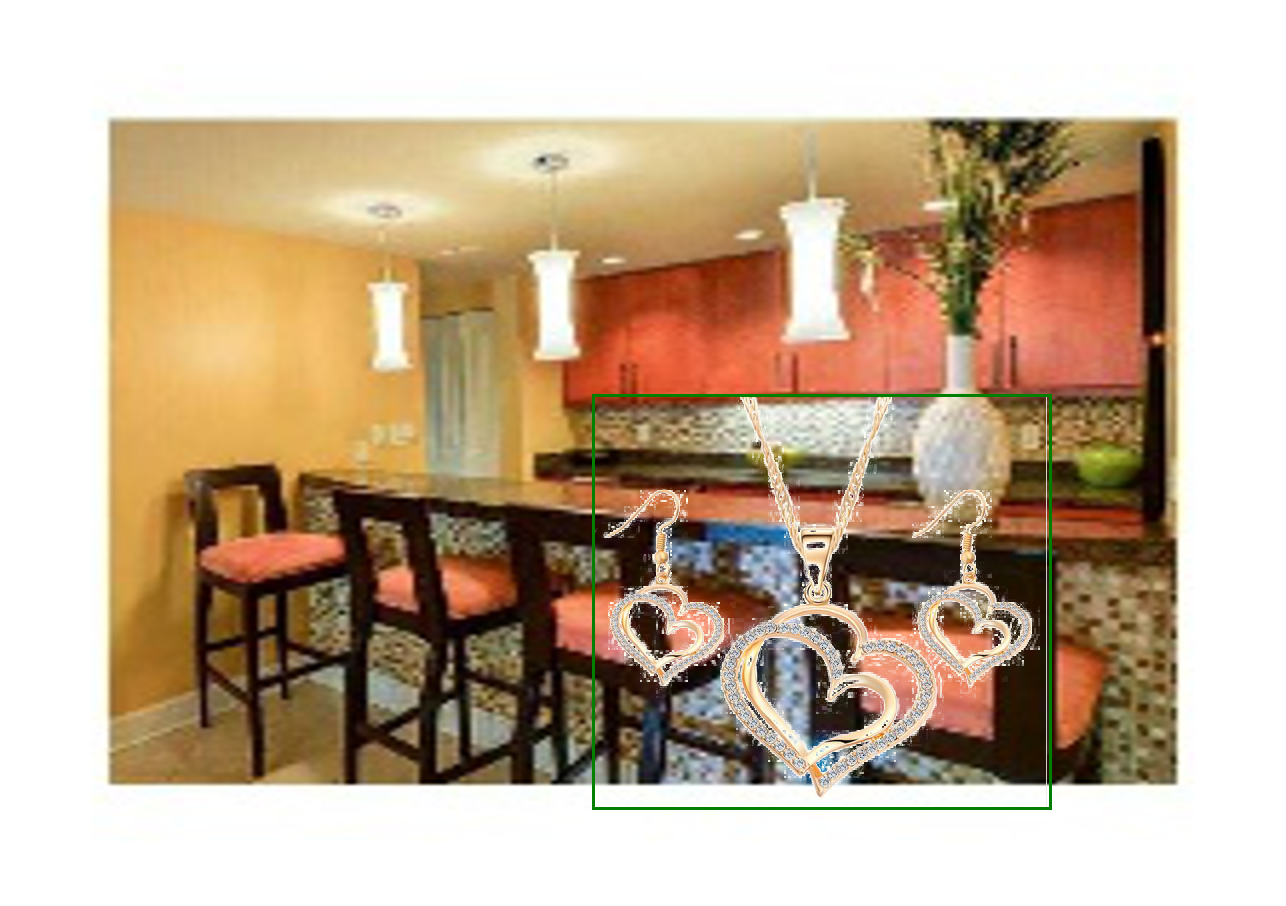

In [15]:
draw_image_with_box(image)

In [16]:
# трансформирование для тестового датасета перед подачей в модель
test_transform = torch.nn.Sequential(    
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),    
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
    )    

# трансформирование для тестового датасета для визуалиазация
resize_transform = torch.nn.Sequential(    
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),    
    )  

In [17]:
def train_transform(image0, segmentation0): 
    '''
    Проводит аугментация изображений тестового датасета
    
    :param image0: изображение типа PIL Image
    :param segmentation0: маска изображения
    :return: original, image, x0, y0, x1, y1, где original - изображение аугментированное для визуализации, 
                                                image - изображение аугментированное нормализованное, 
                                                x0, y0, x1, y1 - координаты detection box
    '''      
    
    
    image = TF.to_tensor(image0)
    segmentation = TF.to_tensor(segmentation0)
    
    # поворот изображение с вероятностью PROBABILITY_AUG_ROTATE
    if random.random() > PROBABILITY_AUG_ROTATE:
        angle = random.random()*360
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle, interpolation=transforms.InterpolationMode.NEAREST, fill=1)        
    
    image = TF.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    segmentation = TF.resize(segmentation, [IMAGE_HEIGHT, IMAGE_WIDTH], interpolation=transforms.InterpolationMode.NEAREST)       
    
    # отражение изображения с вероятностью PROBABILITY_AUG_FLIP
    if random.random() > PROBABILITY_AUG_FLIP:        
        image = TF.hflip(image)
        segmentation = TF.hflip(segmentation)

    original = image         
    
    # изменение насыщенности изображения с вероятностью PROBABILITY_AUG_HUE            
    if random.random() > PROBABILITY_AUG_HUE:        
        image = TF.adjust_hue(image, 0.2-0.4*(random.random())   )
             
    # изменение контрастности изображения с вероятностью PROBABILITY_AUG_ADJUST_CONTRAST     
    if random.random() > PROBABILITY_AUG_ADJUST_CONTRAST:        
        image = TF.adjust_contrast(image, 0.8+0.4*(random.random())  )

    norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
    image =  norm(image) 

    segmentation = segmentation.detach().cpu().numpy()
    segmentation = segmentation.squeeze(0)
    segmentation = segmentation < segmentation.mean()
    
    # ищем координаты detection box в формате x0, y0, x1, y1        
    ax = np.where( segmentation.max(axis=0) == True)[0]      
    if len(ax) == 0:
        x0, x1 = 0, IMAGE_WIDTH        
    else:
        x0, x1 = min(ax), max(ax)        
        
    ax = np.where( segmentation.max(axis=1) == True)[0]          
    if len(ax) == 0:
        y0, y1 = 0, IMAGE_HEIGHT        
    else:
        y0, y1 = min(ax), max(ax)
       
    return original, image, x0, y0, x1, y1

## Проверка работы train_transform

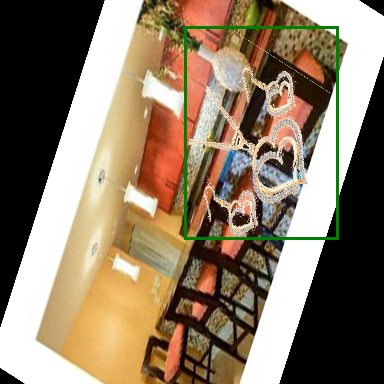

In [18]:
image_main = image.convert('RGB')
mask = image.getchannel(3)

original, i, x0, y0, x1, y1 = train_transform(image_main, mask)

transform = transforms.ToPILImage()
img = transform(original)

show_box = copy.copy(img)
draw=ImageDraw.Draw(show_box)
draw.rectangle([(x0, y0),(x1, y1)],outline="green", width=3)
show_box    

In [19]:
class SegmentationDataset(Dataset):
    def __init__(self, dir_images, is_train='train', transform=test_transform):
        self.dir_images  = dir_images
        self.transform  = transform
        self.is_train = is_train       
        self.images = os.listdir(dir_images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path_image = os.path.join(self.dir_images, self.images[index])   
        image = Image.open(img_path_image)
        
        if self.is_train in ['train']:
            image = add_background(image, k=K_RATIO)
            mask = image.getchannel(3)
            image_main = image.convert('RGB')
            clean_image, aug_image, x0, y0, x1, y1 = self.transform(image_main, mask)
            return clean_image, aug_image, x0, y0, x1, y1       
        
        else:
            image = TF.to_tensor(image)            
            clean_image = resize_transform(image)            
            image = self.transform(image)
            return clean_image, image

In [20]:
train_ds = SegmentationDataset(INPUT_TRANSPARENT_DIR, is_train='train', transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

## Проверка работы DataLoader

In [21]:
iters = next(iter(train_loader))

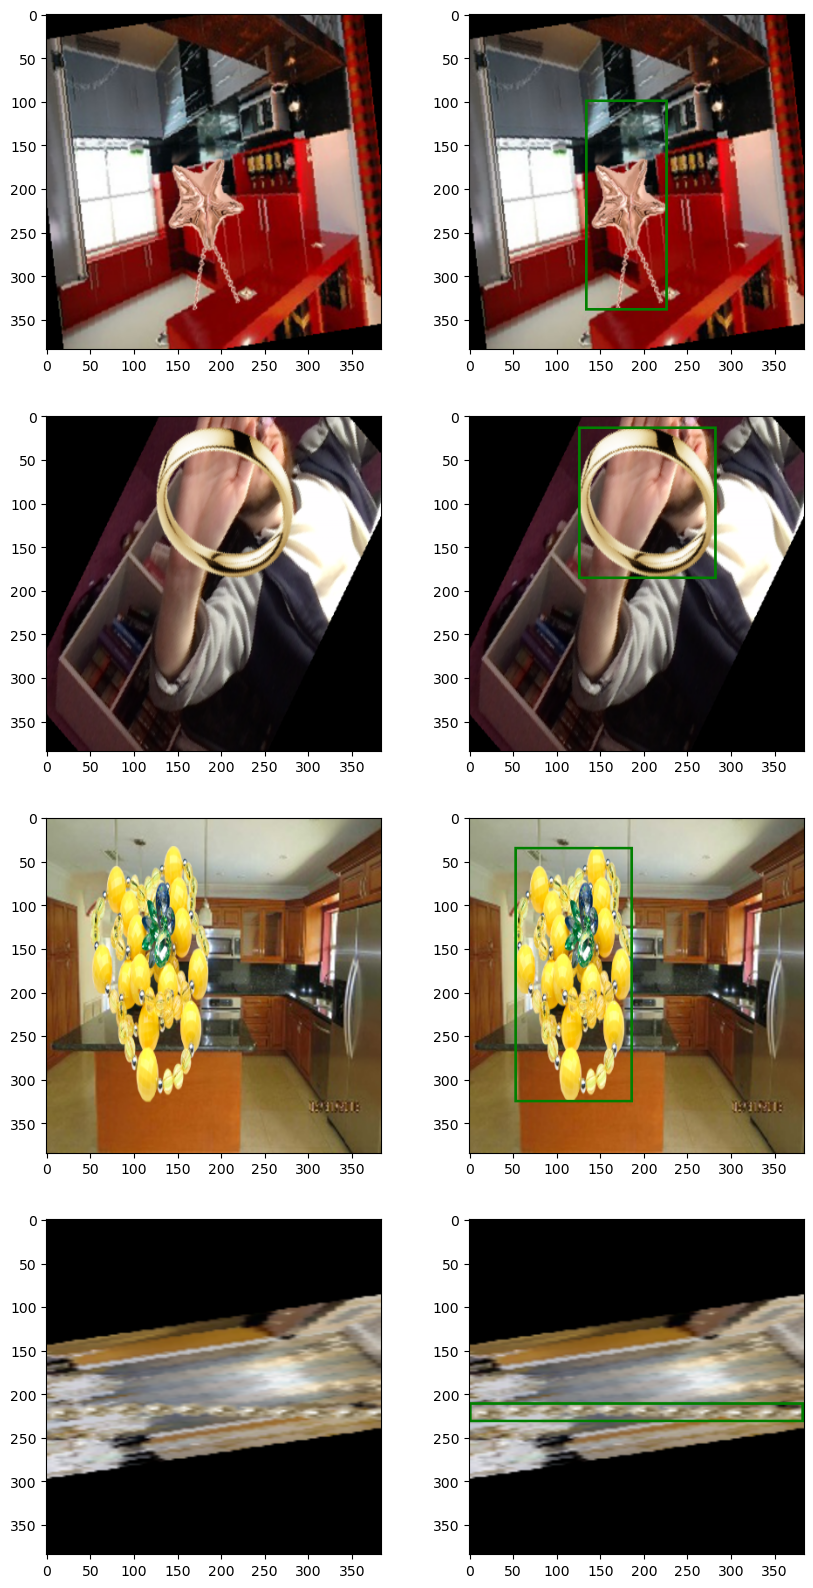

In [22]:
clean_image, aug_image, x0, y0, x1, y1 = iters

transform = transforms.ToPILImage()
rows = 4
_, ax = plt.subplots(rows, 2, figsize=(10,5*rows))
for k in range(rows):
    ax[k][0].imshow(clean_image[k].permute(1,2,0))       
    
    q = transform(clean_image[k])
    
    s = draw_box_on_image(q, x0[k], y0[k], x1[k], y1[k])
    
    ax[k][1].imshow(s)    

In [23]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [24]:
num_classes = 2
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [25]:
model.to(DEVICE)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [26]:
def plot_progress(losses_dict, text='', size=(5, 5)):
    '''
    Выводит график обучения
    
    :param losses_dict: данные для визуализации в виде словаря {x:list, y:list}, где x и y списки значений
    :param text: текста для вывода на изображении
    :return: None
    '''      
        
    clear_output(True)
    
    plt.figure(figsize=size)
    
    for i, v in losses_dict.items():        
        x_array = range(len(v))    
        plt.plot(x_array, v, label = i)
        
    plt.legend()
    plt.grid()
    
    if text != '':
        plt.text (0.05*x_array[-1],0.95*max(v), text)
    
    plt.show()

In [27]:
def train_one_epoch(model, optimizer, data_loader, device):
    '''
    Обучение одной эпохи
    
    :param model: модель
    :param optimizer: optimizer   
    :param data_loader: data_loader
    :param device: device
    :return: None
    '''         
    model.train()

    start_time = time.time()    
    length = len(data_loader)
    
    for i, data in enumerate(data_loader):
        
        clean_image_, image_, x0_, y0_, x1_, y1_ = data

        targets = []
        for j in range(len(clean_image_)):
            targets.append({'boxes': [[x0_[j], y0_[j], x1_[j], y1_[j]]],
                    'labels': [1]           
                   }
            )
                        
        images = list(image.to(device) for image in image_)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]                        
        loss_dict = model(images, targets)
                
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        batch_time = time.time()
        speed = (i+1)/(batch_time-start_time)
        
        history['losses'].append(loss_value)
        
        print(f'step {i+1}/{length}')
        print('[%5d] loss: %.3f, speed: %.2f' %
              (i, loss_value, speed))
                        
        lr_rate_current = optimizer.param_groups[-1]['lr']
        print(f'learing rate {lr_rate_current}')

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            break
                        
        plot_progress(history, text='')

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step()

In [28]:
def train_all_epochs():
    '''
    Обучение всех эпох
    
    :return: None
    '''       
    global history
    history = {'losses' : []}

    for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
        print("------------------ Training Epoch {} ------------------".format(epoch+1))
        train_one_epoch(model, optimizer, train_loader, DEVICE)
        torch.save(model.state_dict(), MODEL_PATH)

    print('Finished Training')

In [29]:
def load_model():
    '''
    Загрзка модели
    
    :return: None
    '''       
    name = NAME_MODEL_FOR_LOADING 
        
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(name))
    else:    
        model.load_state_dict(torch.load(name, map_location=torch.device('cpu')))

In [30]:
# переключение - обучение модели или загрузка модели

# train_all_epochs()
load_model()

## Проверка на тестовом датасете

In [31]:
model.eval()
print()

In [32]:
iters = next(iter(train_loader))

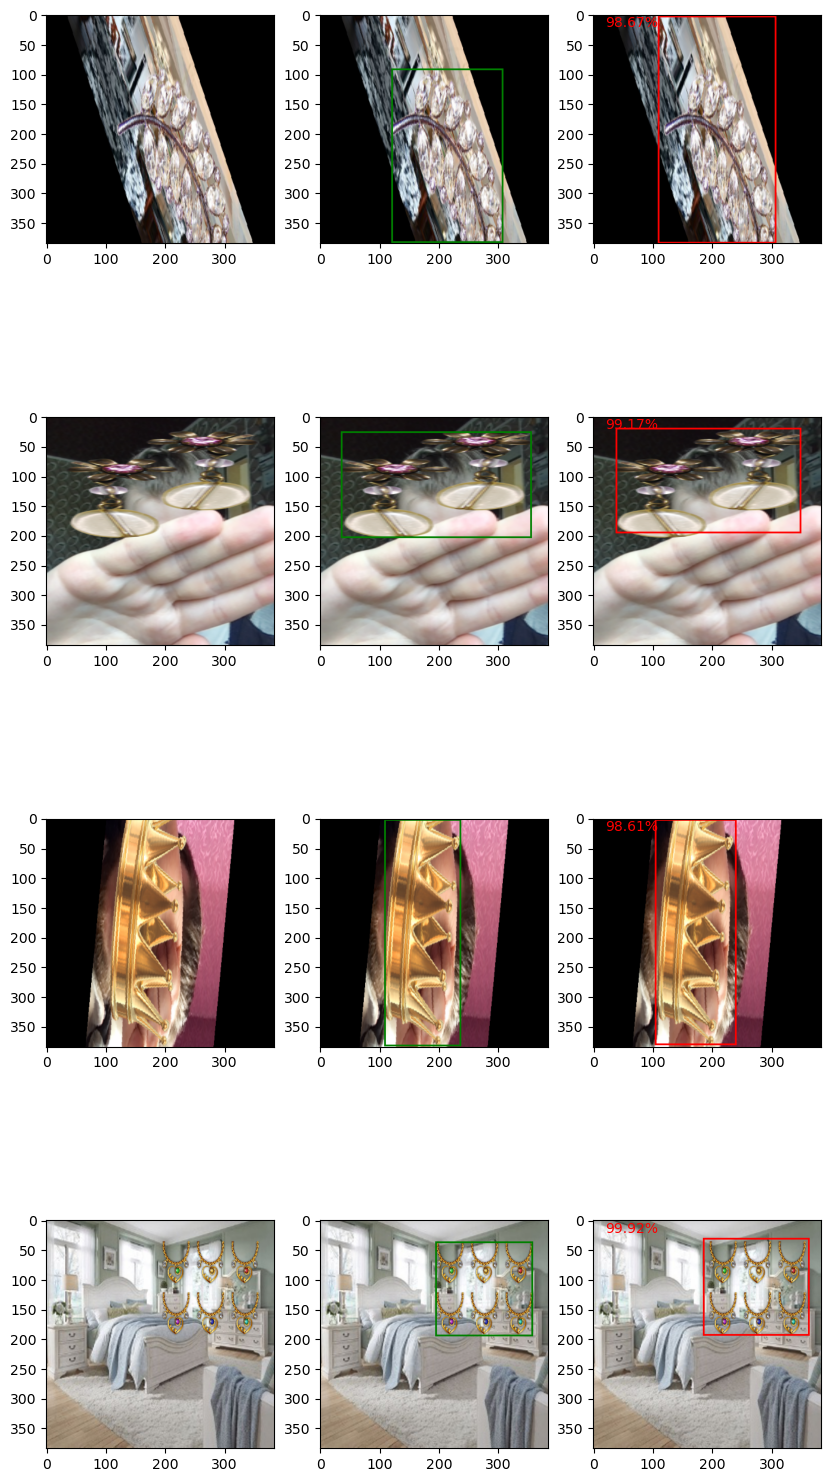

In [33]:
clean_image, aug_image, x0, y0, x1, y1 = iters

aug_image = list(image.to(DEVICE) for image in aug_image)    
predictions = model(aug_image)

transform = transforms.ToPILImage()
rows = len(clean_image)
_, ax = plt.subplots(rows, 3, figsize=(10,5*rows))
for k in range(rows):
    # вывод оригинального изображения
    ax[k][0].imshow(clean_image[k].permute(1,2,0))       
    
    q = transform(clean_image[k])
    
    s = draw_box_on_image(q, x0[k], y0[k], x1[k], y1[k])    
    
    # вывод detection box фактическое
    ax[k][1].imshow(s)   
        
    pred_box = predictions[k]['boxes'][0].tolist()
    pred_score = predictions[k]['scores'][0].item()
    
    # вывод detection box орпделенное моделью
    s = draw_box_on_image(q, *pred_box, color='red')    
    ax[k][2].text(20,20, f'{pred_score:.2%}', color='red')
    ax[k][2].imshow(s)      
    

## Проверка на датасете ААА

In [34]:
aaa_ds = SegmentationDataset(AAA_PATH, is_train='test', transform=test_transform)
aaa_loader = DataLoader(aaa_ds, batch_size=BATCH_SIZE, shuffle=True)

In [35]:
model.eval()
print()

In [36]:
iters = next(iter(aaa_loader))

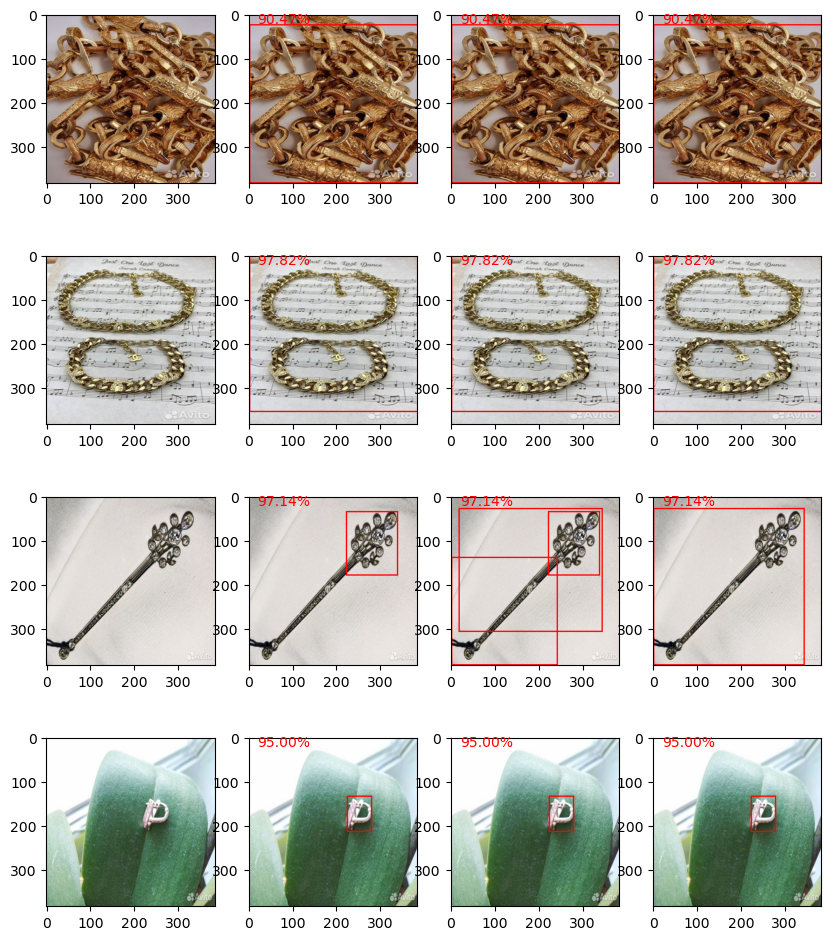

In [37]:
clean_image, aug_image = iters

aug_image = list(image.to(DEVICE) for image in aug_image)    
predictions = model(aug_image)

transform = transforms.ToPILImage()
rows = len(clean_image)
_, ax = plt.subplots(rows, 4, figsize=(10,3*rows))
for k in range(rows):
    # вывод оригинального изображения    
    ax[k][0].imshow(clean_image[k].permute(1,2,0))       
    
    q = transform(clean_image[k])
    
    pred_box = predictions[k]['boxes'][0].tolist()
    pred_score = predictions[k]['scores'][0].item()
    
    # вывод изображения с наилучшей detection box
    s = draw_box_on_image(q, *pred_box, color='red')    
    ax[k][1].text(20,20, f'{pred_score:.2%}', color='red')
    ax[k][1].imshow(s)    
    
    pred_boxs = predictions[k]['boxes']
    pred_scores = predictions[k]['scores']
    
    pred_scores_numpy = pred_scores.detach().cpu().numpy()
   
    
    for threshold in STEPS_FOR_THRESHOLD:
        list_ind = np.where( pred_scores_numpy > max(STEPS_FOR_THRESHOLD))[0]
        ind_max = len(list_ind)
        if ind_max > 0:
            break
    if ind_max == 0:
        ind_max = 1

    pred_boxs_numpy = pred_boxs.detach().cpu().numpy()
    pred_boxs_good = pred_boxs_numpy[:ind_max]
 
    # вывод изображения с наилучшими несколькими detection box
    s = draw_box_on_image_multi(q, pred_boxs_good, color='red')    
    ax[k][2].text(20,20, f'{pred_score:.2%}', color='red')
    ax[k][2].imshow(s)        
    
    best_x0 = min([i[0] for i in pred_boxs_good])
    best_y0 = min([i[1] for i in pred_boxs_good])
    best_x1 = max([i[2] for i in pred_boxs_good])
    best_y1 = max([i[3] for i in pred_boxs_good])
    
    # вывод изображения с объединенной detection box
    s = draw_box_on_image(q, best_x0, best_y0, best_x1, best_y1, color='red')    
    ax[k][3].text(20,20, f'{pred_score:.2%}', color='red')
    ax[k][3].imshow(s)        

# Исследование метрики качества

Исследование метрики качества IoU будет проводиться на основе 100 картинок, размеченных вручную

In [38]:
def train_transform_mask(image0, segmentation0):   
    '''
    Проводит аугментация изображений тестового датасета
    
    :param image0: изображение типа PIL Image
    :param segmentation0: маска изображения
    :return: original, image, x0, y0, x1, y1, mask где original - изображение аугментированное для визуализации, 
                                                image - изображение аугментированное нормализованное, 
                                                x0, y0, x1, y1 - координаты detection box
                                                mask - маска
    '''      
    
       
    image = TF.to_tensor(image0)
    segmentation = TF.to_tensor(segmentation0)
    
    # поворот изображение с вероятностью PROBABILITY_AUG_ROTATE
    if random.random() > PROBABILITY_AUG_ROTATE:
        angle = random.random()*360
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle, interpolation=transforms.InterpolationMode.NEAREST, fill=0)        
    
    image = TF.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    segmentation = TF.resize(segmentation, [IMAGE_HEIGHT, IMAGE_WIDTH], interpolation=transforms.InterpolationMode.NEAREST)       
    
    # отражение изображения с вероятностью PROBABILITY_AUG_FLIP
    if random.random() > PROBABILITY_AUG_FLIP:        
        image = TF.hflip(image)
        segmentation = TF.hflip(segmentation)

    original = image         
            
    # изменение насыщенности изображения с вероятностью PROBABILITY_AUG_HUE            
    if random.random() > PROBABILITY_AUG_HUE:        
        image = TF.adjust_hue(image, 0.2-0.4*(random.random())   )
             
    # изменение контрастности изображения с вероятностью PROBABILITY_AUG_ADJUST_CONTRAST     
    if random.random() > PROBABILITY_AUG_ADJUST_CONTRAST:        
        image = TF.adjust_contrast(image, 0.8+0.4*(random.random())  )

    norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
    image =  norm(image) 

    segmentation = segmentation.detach().cpu().numpy()

    try:
        segmentation = segmentation.squeeze(0)
    except:
        pass
    segmentation = segmentation > segmentation.mean()
    
    # ищем координаты detection box в формате x0, y0, x1, y1        
    ax = np.where( segmentation.max(axis=0) == True)[0]      
    if len(ax) == 0:
        x0, x1 = 0, IMAGE_WIDTH        
    else:
        x0, x1 = min(ax), max(ax)
        
    ax = np.where( segmentation.max(axis=1) == True)[0]          
    if len(ax) == 0:
        y0, y1 = 0, IMAGE_HEIGHT        
    else:
        y0, y1 = min(ax), max(ax)
       
    return original, image, x0, y0, x1, y1, segmentation.astype(int)

In [39]:
class ManualDataset(Dataset):
    def __init__(self, dir_images, is_train='train', transform=test_transform):
        self.transform  = transform
        self.is_train = is_train   
        
        self.dir_images  = os.path.join(dir_images, 'images')     
        self.images = os.listdir(self.dir_images)
        self.dir_masks = os.path.join(dir_images, 'masks')  

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path_image = os.path.join(self.dir_images, self.images[index])   
        image = Image.open(img_path_image)
        
        mask_path_image = self.images[index].split('.')[0] + '.png'
        mask_path_image = os.path.join(self.dir_masks, mask_path_image)   
        mask = Image.open(mask_path_image).getchannel(0)
        mask = ImageChops.invert(mask)
        
        if self.is_train in ['train']:
            image_main = image.convert('RGB')
            clean_image, aug_image, x0, y0, x1, y1, mask = self.transform(image_main, mask)
            return clean_image, aug_image, x0, y0, x1, y1, mask      
        
        else:
            image = TF.to_tensor(image)            
            clean_image = resize_transform(image)            
            image = self.transform(image)
            return clean_image, image

In [40]:
verif_ds = ManualDataset(MANUAL_DIR, is_train='train', transform=train_transform_mask)
verif_loader = DataLoader(verif_ds, batch_size=1, shuffle=True)

In [41]:
model.eval()
print()

In [42]:
def calculateIoU(gtMask, predMask):
    '''
    Расчет метрики IoU
        
    :param gtMask: маска в формате numpy двухмерная
    :param predMask: маска в формате numpy двухмерная    
    :return: Выводит IoU
    '''    
                
    tp = ((gtMask >= 0.5) * (predMask >= 0.5)).sum()
    fp = ((gtMask < 0.5) * (predMask >= 0.5)).sum()
    fn = ((gtMask >= 0.5) * (predMask < 0.5)).sum()    
    
    iou = tp / (tp + fp + fn)

    return iou

In [43]:
iou_metrics = []

for i, data in enumerate(verif_loader):
    clean_image, aug_image, x0, y0, x1, y1, mask = data
    
    mask_real = mask.cpu().detach().numpy()
    mask_real = mask_real.squeeze(0)   
    mask_real = mask_real >= 0.6
        

    ax = np.where(mask_real.max(axis=0) == True)[0]   
    x0, x1 = min(ax), max(ax)
    ax = np.where(mask_real.max(axis=1) == True)[0]  
    y0, y1 = min(ax), max(ax)       
    
    mask_real2 = np.ones(mask_real.shape)
    mask_real2[x1:,:] = 0
    mask_real2[:x0,:] = 0
    mask_real2[:, y1:] = 0
    mask_real2[:, :y0] = 0  
    
    aug_image = list(image.to(DEVICE) for image in aug_image)    
    predictions = model(aug_image)      
            
   
    pred_box = predictions[0]['boxes'][0].tolist()
    pred_score = predictions[0]['scores'][0].item()
    
    pred_boxs = predictions[0]['boxes']
    pred_scores = predictions[0]['scores']
    
    pred_scores_numpy = pred_scores.detach().cpu().numpy()
   
    
    for threshold in STEPS_FOR_THRESHOLD:
        list_ind = np.where( pred_scores_numpy > max(STEPS_FOR_THRESHOLD))[0]
        ind_max = len(list_ind)
        if ind_max > 0:
            break
    if ind_max == 0:
        ind_max = 1

    pred_boxs_numpy = pred_boxs.detach().cpu().numpy()
    pred_boxs_good = pred_boxs_numpy[:ind_max]
 
    # вывод изображения с наилучшими несколькими detection box
    best_x0 = round(min([i[0] for i in pred_boxs_good]))
    best_y0 = round(min([i[1] for i in pred_boxs_good]))
    best_x1 = round(max([i[2] for i in pred_boxs_good]))
    best_y1 = round(max([i[3] for i in pred_boxs_good]))    
   
    mask_pred2 = np.ones(mask_real.shape)
    
    mask_pred2[best_x1:,:] = 0
    mask_pred2[:best_x0,:] = 0
    mask_pred2[:, best_y1:] = 0
    mask_pred2[:, :best_y0] = 0
      

    iou = calculateIoU(mask_real2, mask_pred2)
    iou_metrics.append(iou)
    
    clear_output()
    print(f'{(i+1) / len(verif_loader):.1%}')      
    
iou_metrics = np.array(iou_metrics)

100.0%


In [44]:
mean_iou = np.array(iou_metrics).mean()
std_iou = np.array(iou_metrics).std()

In [45]:
print(f'Iou = {mean_iou:.1%} ± {std_iou:.1%}')

Iou = 63.2% ± 25.1%
